In [1]:
# décommenter cette ligne si nbtutor est installé
# %load_ext nbtutor

In [2]:
from callstats import CallRecorder

In [3]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """

   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style('custom/custom.css')

<div style='width:20em'><img src='img/logo-igm.png'></div>
<div style='font-size:larger'><strong>Algorithmique et programmation 2</strong><br>
L1 Mathématiques - L1 Informatique<br>
Semestre 2
</div>

# Récursivité

## Appels de fonctions et pile d'appels

### Une petite histoire

- Vous allez chez G. en lisant un bouquin  
    - Arrivée à la station, vous commencez à consulter le plan  
        - R. appelle pour vous proposer un cinéma demain  
            - Vous consultez le programme  
            - Vous trouvez un film qui vous plaît  
        - Vous vous mettez d'accord avec R.  
    - Vous finissez de chercher votre ligne de métro  
- Vous reprenez votre lecture à la bonne page

Un être humain sait faire ça (un peu), **mais une machine** ?

### Les appels de fonctions
  
-   Un programme utilise des fonctions (pré-définies ou non)
-   Certaines fonctions font appel à d'autres fonctions
-   Au moment de l'appel, l'exécution de la fonction appelante s'interrompt
-   Après un appel, l'exécution doit reprendre au bon endroit, et avec les
    bonnes valeurs des variables  

<img src='img/appelrec.png' width=50%></img>

### Exemple : quelques tâches simples

**Exercice :**
Décrivez l'exécution du programme suivant, l'évolution de la pile
d'appels et les affichages

In [4]:
#%%nbtutor -r -f -d 10

def pgcd(a, b):
    while b:
        a, b = b, a % b
    return a

def simplifier(fraction):
    d = pgcd(fraction[0], fraction[1])
    res = (fraction[0] // d, fraction[1] // d)
    return res

def ajouter(frac1, frac2):
    denom = frac1[1] * frac2[1]
    num = frac1[0] * frac2[1] + frac2[0] * frac1[1]
    res = simplifier((num, denom))
    return res

frac = ajouter((1, 3), (1, 6))

In [5]:
frac

(1, 2)

In [6]:
@CallRecorder
def pgcd(a, b):
    while b:
        a, b = b, a % b
    return a

@CallRecorder
def simplifier(fraction):
    d = pgcd(fraction[0], fraction[1])
    res = (fraction[0] // d, fraction[1] // d)
    return res

@CallRecorder
def ajouter(frac1, frac2):
    denom = frac1[1] * frac2[1]
    num = frac1[0] * frac2[1] + frac2[0] * frac1[1]
    res = simplifier((num, denom))
    return res

In [7]:
my_call = ajouter((1, 3), (1, 6))
print(my_call.trace())

ajouter((1, 3), (1, 6))
 │ simplifier((9, 18))
 │  │ pgcd(9, 18)
 │  │  └─> 9
 │  └─> (1, 2)
 └─> (1, 2)


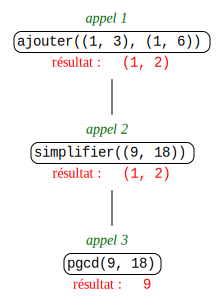

In [8]:
my_call.graph()

### Pile d'appels

**Pile d'appels :** liste ordonnée de tâches en cours
  
-   « Fond » de la pile : première tâche commencée (la plus ancienne)
-   « Sommet » de la pile : dernière tâche commencée (la plus récente)  

  

  Chaque élément de pile <!-- $1 -->
  contient :
  
  -   Valeur des paramètres de la fonction en cours
  -   Position du site d'appel (instruction à exécuter au retour)
  -   Variables locales à la fonction, état de l'interpréteur
  

### Fonctionnement de la pile

  À chaque nouvel **appel** :
  -   La fonction appelante évalue chaque paramètre et met sur la pile (des références à) ces valeurs
  -   L'appelante sauvegarde son état (ou *contexte*) pour
    pouvoir reprendre son exécution une fois l'appel terminé
  -   L'interpréteur donne la main à la fonction appelée
  -   L'appelée démarre son exécution, en plaçant ses éventuelles
    variables locales au sommet de la pile  

À chaque nouveau **retour** de fonction :
  
-   L'appelée dépose à un endroit convenu sa valeur de retour
-   L'appelée détruit (« dépile ») toutes ses données locales
-   L'interpréteur rend la main à la fonction appelante
-   L'appelante récupère la valeur de retour et reprend son exécution

Les détails (qui fait quoi, où, comment) dépendent de l'implémentation

### Exemple : périmètre d'un polygone

In [9]:
#%%nbtutor -r -f -d 3

def distance(p, q):
    '''Renvoie la longueur du côté
    defini par p et q.'''
    dx = (p[0] - q[0])
    dy = (p[1] - q[1])
    res = (dx ** 2 + dy ** 2) ** 0.5
    return res

def perimetre(P):
    '''Renvoie le périmètre du polygone 
    défini par la liste P de points.'''
    retval = 0
    for i in range(-1, len(P) - 1):
        d = distance(P[i], P[i+1])
        retval += d
    return retval

p = perimetre([(0, 0), (0, 1), (1, 1), (1, 0)])

In [10]:
p

4.0

In [11]:
@CallRecorder
def distance(p, q):
    '''Renvoie la longueur du côté
    defini par p et q.'''
    dx = (p[0] - q[0])
    dy = (p[1] - q[1])
    res = (dx ** 2 + dy ** 2) ** 0.5
    return res

@CallRecorder
def perimetre(P):
    '''Renvoie le périmètre du polygone 
    défini par la liste P de points.'''
    retval = 0
    for i in range(-1, len(P) - 1):
        d = distance(P[i], P[i+1])
        retval += d
    return retval

my_call = perimetre([(0, 0), (0, 1), (1, 1), (1, 0)])
print(my_call.trace())

perimetre([(0, 0), (0, 1), (1, 1), (1, 0)])
 │ distance((1, 0), (0, 0))
 │  └─> 1.0
 │ distance((0, 0), (0, 1))
 │  └─> 1.0
 │ distance((0, 1), (1, 1))
 │  └─> 1.0
 │ distance((1, 1), (1, 0))
 │  └─> 1.0
 └─> 4.0


## Programmation récursive

### Principe

C'est le même principe que le raisonnement ou la définition par récurrence en math !

**Idée fondamentale :**
Puisque une fonction peut en appeler une autre, pourquoi une fonction ne pourrait-elle pas s'appeler elle-même ?

### Exemple : somme et produit 

Voici une proposition de définition « récurrente » de la somme et du produit de deux entiers positifs. 

Pour tous entiers positifs $a$ et $b$, on a:

$$
a + b = 
\begin{cases}
  a & \text{si } b = 0,
  \\
  \big(a + (b - 1)\big) + 1 & \text{sinon.}
\end{cases}
$$
$$
a \times b = 
\begin{cases}
  0 & \text{si } b = 0,
  \\
  \big(a \times (b - 1)\big) + a & \text{sinon.}
\end{cases}
$$

Voici une fonction Python qui imite la définition du produit :

In [12]:
#%%nbtutor -r -f -d 5
   
def produit(a, b):
    """Calcule le produit de a par b (entier positif), 
    sans utiliser l'opérateur « * » !"""
    if b == 0:
        res = 0
        return res
    else:
        res = a + produit(a, b-1)
        return res
    
p = produit(4, 3)

In [13]:
p

12

Autre visualisation possible :

In [14]:
@CallRecorder
def produit(a, b):
    """Calcule le produit de a par b (entier positif), 
    sans utiliser l'opérateur « * » !"""
    if b == 0:
        return 0
    else:
        return a + produit(a, b-1)
    
my_call = produit(4, 3)
print(my_call.trace())

produit(4, 3)
 │ produit(4, 2)
 │  │ produit(4, 1)
 │  │  │ produit(4, 0)
 │  │  │  └─> 0
 │  │  └─> 4
 │  └─> 8
 └─> 12


**Exercice :** programmer de manière semblable une fonction récursive calculant $a + b$.

In [15]:
#%%nbtutor -r -f -d 5
   
def somme(a, b):
    """Calcule la somme de a et b (entier positif), 
    avec seulement (+ 1) !"""
    if b == 0:
        return a
    else:
        return somme(a, b-1) + 1
    
somme(4, 3)

7

### Exemple: factorielle

Rappel: la **factorielle de $n$** est définie par :

$$ 
n! = \begin{cases}
  1 \text{ si $n = 0$}\\
  n\times(n-1)\cdot(n-2)\cdots 2\cdot1 \text{ sinon}
\end{cases}
$$

Calcul itératif de $n!$ :

In [16]:
def facto(n):
    '''
    >>> facto(5) == 5*4*3*2*1
    True
    '''
    f = 1
    for i in range(2, n + 1):
        f *= i
    return f

facto(5)

120

Ou sous forme récursive :

$$
n! = \begin{cases}
      1 \text{ si $n = 0$}\\
      n \times (n-1)! \text{ sinon}
    \end{cases}
$$

Calcul récursif de $n!$ :

In [17]:
#%%nbtutor -r -f -d 10

def facto(n):
    """
    Attention, n entier >=0 sinon je plante.
    """
    if n == 0:
        return 1
    else:
        return n * facto(n - 1)
    
facto(5)

120

In [18]:
@CallRecorder
def facto(n):
    if n == 0:
        return 1
    else:
        return n * facto(n - 1)
    
print(facto(5).trace())

facto(5)
 │ facto(4)
 │  │ facto(3)
 │  │  │ facto(2)
 │  │  │  │ facto(1)
 │  │  │  │  │ facto(0)
 │  │  │  │  │  └─> 1
 │  │  │  │  └─> 1
 │  │  │  └─> 2
 │  │  └─> 6
 │  └─> 24
 └─> 120


### Exemple : puissance

On a déjà vu comment calculer $a^n=\overbrace{a\times a\times \cdots\times a}^{\mbox{$n$ termes}}$, avec le cas particulier $a^0=1$

Calcul itératif de $a^n$ :

In [19]:
def puiss(a, n):
    p = 1
    for i in range(1, n + 1):
        p *= a
    return p

puiss(2, 3)

8

On peut aussi définir $a^n$, pour $n\in \mathbb{N}$, de manière récursive:

$$
a^n = \begin{cases}
1 & \text{ si } n=0\\
a \times a^{n-1} & \text{ sinon}
\end{cases}
$$

Calcul récursif de $a^n$ :

In [20]:
@CallRecorder
def puissR(a, n):
    if n == 0:
        return 1
    else:
        return a * puissR(a, n - 1)
    
print(puissR(2, 3).trace())

puissR(2, 3)
 │ puissR(2, 2)
 │  │ puissR(2, 1)
 │  │  │ puissR(2, 0)
 │  │  │  └─> 1
 │  │  └─> 2
 │  └─> 4
 └─> 8


### Exemple : pgcd

Le plus grand diviseur commun à deux entiers positifs ou nuls $a$ et $b$ peut être défini comme :

$$
\mathrm{pgcd}(a, b) = \begin{cases}a & \text{ si $b = 0$,}\\\mathrm{pgcd}(b, a \bmod b) & \text{ sinon}\end{cases}
$$

In [21]:
#%%nbtutor -r -f -d 10

def pgcd(a, b):
    if b == 0:
        return a
    else:
        return pgcd(b, a % b)

pgcd(2*5*7, 2*3*5*11)

10

In [22]:
@CallRecorder
def pgcd(a, b):
    if b == 0:
        return a
    else:
        return pgcd(b, a % b)

call = pgcd(2*5*7, 2*3*5*11)
print(call.trace())

pgcd(70, 330)
 │ pgcd(330, 70)
 │  │ pgcd(70, 50)
 │  │  │ pgcd(50, 20)
 │  │  │  │ pgcd(20, 10)
 │  │  │  │  │ pgcd(10, 0)
 │  │  │  │  │  └─> 10
 │  │  │  │  └─> 10
 │  │  │  └─> 10
 │  │  └─> 10
 │  └─> 10
 └─> 10


### Méthode générale

1. Pour les instances les plus simples ("cas de base"), donner la solution directe
1. Pour les cas complexes, se ramener à une ou plusieurs instances "plus simples" du même problème
1. Combiner les solutions des instances plus simples pour résoudre le problème initial

"Plus simple" : varie selon le contexte. Exemples :
-   $P$ et $P'$ sont des naturels et $P'<P$
-   $P$ est une liste et $P'$ est une liste plus courte
-   $P = (a, b)$ et $P' = (a', b')$ sont des couples de nombres et $a' < a$ ou $(a' = a$ et $b' < b)$
-   $P = (a, b)$ et $P' = (a', b')$ sont des couples de nombres et $\mathrm{abs}(b'-a') < \mathrm{abs}(b-a)$
-   $\ldots$

De manière générale "plus simple" veut dire "plus proche du cas de base"

#### Fonction récursive typique :

```python
def f(P):  # P = parametre(s)
    if test(P):
        # bloc sans appel recursif : cas de base
        return ...
    else:
        # bloc avec appel(s) recursif(s) utilisant
        # des parametres "plus simples"
        return ...
```

## Erreurs fréquentes

### Conditions d'arrêt

In [24]:
def fact(n):
    print(n, end=" ")
    return n * fact(n-1)

fact(4)

4 3 2 1 0 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -11 -12 -13 -14 -15 -16 -17 -18 -19 -20 -21 -22 -23 -24 -25 -26 -27 -28 -29 -30 -31 -32 -33 -34 -35 -36 -37 -38 -39 -40 -41 -42 -43 -44 -45 -46 -47 -48 -49 -50 -51 -52 -53 -54 -55 -56 -57 -58 -59 -60 -61 -62 -63 -64 -65 -66 -67 -68 -69 -70 -71 -72 -73 -74 -75 -76 -77 -78 -79 -80 -81 -82 -83 -84 -85 -86 -87 -88 -89 -90 -91 -92 -93 -94 -95 -96 -97 -98 -99 -100 -101 -102 -103 -104 -105 -106 -107 -108 -109 -110 -111 -112 -113 -114 -115 -116 -117 -118 -119 -120 -121 -122 -123 -124 -125 -126 -127 -128 -129 -130 -131 -132 -133 -134 -135 -136 -137 -138 -139 -140 -141 -142 -143 -144 -145 -146 -147 -148 -149 -150 -151 -152 -153 -154 -155 -156 -157 -158 -159 -160 -161 -162 -163 -164 -165 -166 -167 -168 -169 -170 -171 -172 -173 -174 -175 -176 -177 -178 -179 -180 -181 -182 -183 -184 -185 -186 -187 -188 -189 -190 -191 -192 -193 -194 -195 -196 -197 -198 -199 -200 -201 -202 -203 -204 -205 -206 -207 -208 -209 -210 -211 -212 -213 -214 -215 -216 -217 -218 -219 -22

RecursionError: maximum recursion depth exceeded

-   Erreur d'exécution : saturation de la pile
-   Oubli de la condition d'arrêt (cas de base)
-   Solution : toujours commencer par le(s) cas de base

In [25]:
def fact(n):
    if n == 0:
        return 1
    else:
        return n * fact(n-1)

fact(4)

24

### Conditions d'arrêt et appels récursifs

In [26]:
def f(n): # n naturel
    if n == 0:
        print("!")
        #return None
    else:
        print("*", end="")
        f(n)
        #return None
        
f(4)

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

RecursionError: maximum recursion depth exceeded

La fonction ne s'arrête jamais car si $n$ ne vaut pas $0$ au début, il ne vaudra jamais $0$

In [27]:
def f(n): # n naturel
    if n == 0:
        print("!")
    else:
        print("*", end="")
        f(n-1)
        
f(10)

**********!


### Limite de capacité de la pile

Chaque appel récursif stocke des informations sur la pile d'appel ("bloc" d'exécution de la fonction, en anglais *frame*), donc il est nécessaire de limiter la taille totale de la pile.

In [30]:
res = fact(2958)

In [31]:
res = fact(3000)

RecursionError: maximum recursion depth exceeded

-   La fonction est correcte, mais erreur si dépassement de la hauteur maximale de la pile
-   *Réglable, mais dans une certaine limite...*

In [32]:
from sys import setrecursionlimit
setrecursionlimit(10000)
f(9500)

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

### Exercice

Qu'affichent les appels de fonctions suivants ?

In [33]:
def fonction1(n):
    if n == 0:
        print(n)
    else:
        print(n, end=' ')
        fonction1(n-1)
        
fonction1(10)

10 9 8 7 6 5 4 3 2 1 0


In [34]:
def fonction2(n):
    if n == 0:
        print(n, end=' ')
    else:
        fonction2(n-1)
        print(n, end=' ')
        
fonction2(10)

0 1 2 3 4 5 6 7 8 9 10 

In [35]:
def fonction3(n):
    if n == 0:
        print(n, end=' ')
    else:
        print(n, end=' ')
        fonction3(n-1)
        print(n, end=' ')
        
fonction3(10)

10 9 8 7 6 5 4 3 2 1 0 1 2 3 4 5 6 7 8 9 10 

### Exemple : termine-t-elle ?

Pour un certain entier $a$ donné, on définit la suite de Syracuse $(S^a_n)_{n \geq 0}$ de premier terme $a$ par $S^a_0 = a$ et pour tout $n \geq 1$, 

$$
\begin{cases}
S^a_n = S^a_{n-1} / 2 & \text{ si $S^a_{n-1}$ est pair} \\
S^a_n = 3 \cdot S^a_{n-1} +1 & \text{ sinon }
\end{cases}
$$

On cherche à savoir quel est le plus petit rang $n$ tel que $S^a_n = 1$.

In [36]:
def suivant(terme):
    if terme % 2 == 0:
        return terme // 2
    else:
        return 3*terme + 1    

def temps(a):
    if a == 1:
        print(1)
        return 0
    else:
        print(a, end=' ')
        s = suivant(a)
        return 1 + temps(s)

In [39]:
temps(7)

7 22 11 34 17 52 26 13 40 20 10 5 16 8 4 2 1


16

In [40]:
for i in range(1,10):
    print("temps de vol à partir de", i, ":", temps(i))
    print()

1
temps de vol à partir de 1 : 0

2 1
temps de vol à partir de 2 : 1

3 10 5 16 8 4 2 1
temps de vol à partir de 3 : 7

4 2 1
temps de vol à partir de 4 : 2

5 16 8 4 2 1
temps de vol à partir de 5 : 5

6 3 10 5 16 8 4 2 1
temps de vol à partir de 6 : 8

7 22 11 34 17 52 26 13 40 20 10 5 16 8 4 2 1
temps de vol à partir de 7 : 16

8 4 2 1
temps de vol à partir de 8 : 3

9 28 14 7 22 11 34 17 52 26 13 40 20 10 5 16 8 4 2 1
temps de vol à partir de 9 : 19



-   Fonction `suivant` : terme suivant de la suite de Syracuse
-   Temps de vol : résultat de `temps(n)`
-   *Personne* n'a encore réussi à prouver qu'elle termine toujours !
-   L'évolution du temps de vol de la suite fait des choses inattentues... (*source : Wikipedia*)

<img src='https://upload.wikimedia.org/wikipedia/commons/b/b9/Collatz-stopping-time.svg' width='50%'></img>

### Exercice

Pour convertir un nombre $n$ en base 2, on peut :

1. Calculer le quotient $q$ et le reste $r$ de $n$ par 2
2. Convertir $q$ en base 2
3. Ajouter $r$ comme dernier chiffre au résultat obtenu

Écrire une fonction récursive convertissant $n$ en base 2 (renvoie une liste de *bits*), puis dans une base $b$ quelconque.

In [ ]:
def decimal_vers_binaire(n):    
    if n < 2:
        return [n]
    else:
        q, r = divmod(n, 2)  # étape 1
        res = decimal_vers_binaire(q)  # étape 2
        res.append(r)
        return res
    
decimal_vers_binaire(3422)

In [ ]:
def decimal_vers_base(n, b):    
    if n < b:
        return [n]
    else:
        q, r = divmod(n, b)  # étape 1
        res = decimal_vers_base(q, b)  # étape 2
        res.append(r)
        return res
    
decimal_vers_base(3422, 2)

In [ ]:
decimal_vers_base(3422, 8)

### Exercice

La suite de Fibonacci $(F_n)_{n \geq 0}$ est définie par :

$$
\begin{cases}
F_0 = F_1 = 1\\
F_n = F_{n-1} + F_{n-2} & \text{ pour tout } n \geq 2
\end{cases}
$$

Écrire une fonction récursive calculant le $n$-ème terme $F_n$ de la suite de Fibonacci

In [ ]:
def fibonacci(n):
    if n <= 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

In [ ]:
for i in range(20):
    print(fibonacci(i))

Combien d'appels récursifs cette fonction réalise-t-elle au total pour $n = 5$ ? Pour $n = 10$ ? On peut compter à la main, ou bien demander à la fonction de compter...

In [ ]:
def fibonacci(n):
    if n <= 1:
        return 1, 1
    else:
        a, cpt1 = fibonacci(n-1)
        b, cpt2 = fibonacci(n-2)
        return a + b, cpt1 + cpt2 + 1

In [ ]:
fibonacci(9)

In [ ]:
fibonacci(35)

In [ ]:
fibonacci(40)  # long !!

Visualisons l'ensemble des appels, organisé sous la forme d'un arbre :

In [ ]:
@CallRecorder
def f(n):
    if n <= 1:
        return 1
    else:
        return f(n-1) + f(n-2)

In [ ]:
f(5).graph(verbose_labels=True)

Le problème est que certains appels sont répétés un très grand nombre de fois (on calcule plusieurs fois la même chose...). On dira dans la suite du cours que cette fonction a une *complexité exponentielle* (ce qui est énorme).

In [6]:
f(15).render(verbose_labels=False, prog='neato')